## Neighbourhood Based Collaborative Filtering 
- importing libraries and data
- finding similarities
    - user-user cosine similarity
    - item-item cosine similarity
- Item-item Based Collaborative Filtering (CF) (IBCF)
    - adjusted cosine similarity
    - building model
    - k-fold cross validation
    - hold-out validation
    - statistical and descision based accuracy measurment

### importing libraries

In [26]:
from scipy.stats import norm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold
from collections import defaultdict
import math
from datetime import datetime
import random
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import collections
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
import logging
from sklearn.metrics.pairwise import cosine_similarity
import pickle

- importing data

In [27]:
url = 'https://drive.google.com/file/d/1KbNla9qUZEvscEFbRe767Lq0N-xB2Uoo/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
result = pd.read_csv(path)
result.head()

,user_id,layout_id,ratings
0,u 2,L1,1.0
1,u 3,L1,1.0
2,u 3,L5,1.0
3,u 4,L1,1.0
4,u 4,GLHS2,1.0


## Memory-based/Neighborhood-based recommender system

In [28]:
# creating a pivot table
layout_table = result.pivot_table( values='ratings', index='user_id', columns=['layout_id'])
layout_table

layout_id,GLHS1,GLHS2,GLHS3,GLHS4,GLHS5,L1,L2,L3,L4,L5
user_id,,,,,,,,,,
u 11,1.0,1.0,1.0,1.0,NaN,NaN,5.0,3.0,4.0,5.0
u 12,NaN,NaN,NaN,NaN,1.0,NaN,4.0,3.0,4.0,NaN
u 13,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
u 14,2.0,2.0,2.0,2.0,4.0,NaN,NaN,NaN,4.0,NaN
u 2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
u 3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
u 4,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
u 7,2.0,2.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,3.0
u 9,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0


- many ways to implement the neighborhood or memory based RS. such as jaccard similarity, cosine similarity or adjusted/centered consine similarity matrix.
-Jaccard Similiraity
    - Jaccard Similiraity (JS) doesn't include the ratings but the number of common items visited by the userA and userB divided by the total number of items visited by the userA and userB
    - the problem in JS is that it is completely ignoring the ratings but focuses on the common items and total number of item in user vector
- Cosine Similarity
    - To overcome the problem Consine Similarity(CS) could be the solution, That includes the ratings given by the users to each item by first filling the nan with 0 and then find the angle between the items/user vectors. 
    - smaller the distance higher the similarity and vice-versa 
    - Again, In CS similarity, firstly, fill nan with 0 and 0 is considered as negative that is a bad rating for an item to adjust this issue adjusted/centered consine similarity comes in
- Adjusted/Centered Cosine Similarity
    - Adjusted/Centered Consine Similarity (ACS) doesn't include the nan values but only the values existing in the table. 
    - then finds the mean of each row vector and to normalize ratings in the row vector, subtracts the mean of a row vector from the each actual rating of that row vector.
    - afterwards if the each value of the resultant row vector is added up then the result will be 0, and that mean every values are zero centered.
    - if now the center is zero then the nan value can be considered as zero.
    - because now the mean or average of the ratings in a row vector is 0 so the positive values are considered as positive rating less the zero are the negative ratings
    - the negnitude of the likeness and dislikeness or positivity and negativity can be found by the cosine angle that will give the magnitude of similarity 
    between two row vectors that could be -ve or +ve
    - row vector could be items or users if users are in the row then we're finding similarity among users if the items are in the row then the similarity between the users is found.
    - advantage of using ACS is that it doesn't consider the missing values as nagative but the average.
    - it also handles the tough as well as easy raters. tough raters  barely give good ratings or explors new things on layouts but easy raters tent to be flexible in either star ratings and explopring new layouts or items.

### finding similarity among users for testing

In [29]:
#normalizing the ratings of users row vector
def normalize(row):
    # each row vector is subtracted from mean to centralize the values arround zero and dividing with range of ratings 
    x = row
    new_rows = (row - row.mean()/row.max() - row.min())
    return new_rows
new_rows = layout_table.apply(normalize)
new_rows

layout_id,GLHS1,GLHS2,GLHS3,GLHS4,GLHS5,L1,L2,L3,L4,L5
user_id,,,,,,,,,,
u 11,-0.7,-0.7,-0.666667,-0.75,NaN,NaN,3.333333,1.166667,2.1875,3.45
u 12,NaN,NaN,NaN,NaN,-0.5,NaN,2.333333,1.166667,2.1875,NaN
u 13,NaN,NaN,NaN,NaN,NaN,-0.6,NaN,NaN,NaN,NaN
u 14,0.3,0.3,0.333333,0.25,2.5,NaN,NaN,NaN,2.1875,NaN
u 2,NaN,NaN,NaN,NaN,NaN,-0.6,NaN,NaN,NaN,NaN
u 3,NaN,NaN,NaN,NaN,NaN,-0.6,NaN,NaN,NaN,-0.55
u 4,-0.7,-0.7,NaN,NaN,NaN,-0.6,NaN,-0.833333,NaN,NaN
u 7,0.3,0.3,NaN,NaN,NaN,0.4,NaN,1.166667,NaN,1.45
u 9,-0.7,-0.7,-0.666667,NaN,-0.5,NaN,-0.666667,NaN,-0.8125,0.45


In [30]:
# finding similarity among users
# as every rating is centered to zero and normalized so fill the nan with zero because zero is average ratings
new_rows = new_rows.fillna(0)
# after filling up the values with avg ratings i.e. 0 apply cosine similarity, that will output the value
#  shows the magnitude of the similarity among users
similarity_users_matrix = cosine_similarity(new_rows)
print(type(similarity_users_matrix))
user_similarity_df = pd.DataFrame(similarity_users_matrix, index=layout_table.index,columns = layout_table.index)
user_similarity_df

<class 'numpy.ndarray'>


user_id,u 11,u 12,u 13,u 14,u 2,u 3,u 4,u 7,u 9
user_id,,,,,,,,,
u 11,1.000000,0.725053,0.000000,0.210014,0.000000,-0.417717,0.000977,0.546066,-0.106118
u 12,0.725053,1.000000,0.000000,0.304426,0.000000,0.000000,-0.198086,0.202818,-0.518859
u 13,0.000000,0.000000,1.000000,0.000000,1.000000,0.737154,0.420657,-0.205098,0.000000
u 14,0.210014,0.304426,0.000000,1.000000,0.000000,0.000000,-0.087255,0.027349,-0.629732
u 2,0.000000,0.000000,1.000000,0.000000,1.000000,0.737154,0.420657,-0.205098,0.000000
u 3,-0.417717,0.000000,0.737154,0.000000,0.737154,1.000000,0.310089,-0.653578,-0.176101
u 4,0.000977,-0.198086,0.420657,-0.087255,0.420657,0.310089,1.000000,-0.586757,0.397908
u 7,0.546066,0.202818,-0.205098,0.027349,-0.205098,-0.653578,-0.586757,1.000000,0.069041
u 9,-0.106118,-0.518859,0.000000,-0.629732,0.000000,-0.176101,0.397908,0.069041,1.000000


- In next heatmap similarity score ranges between 1 and -1
    - Maximum similarity exists if similarity score is 1
    - No similarity exists if similarity score is 0
    - dissimiarity exists if similarity score is less than 0

<AxesSubplot:title={'center':'Cosine similarities among the users'}, xlabel='user_id', ylabel='user_id'>

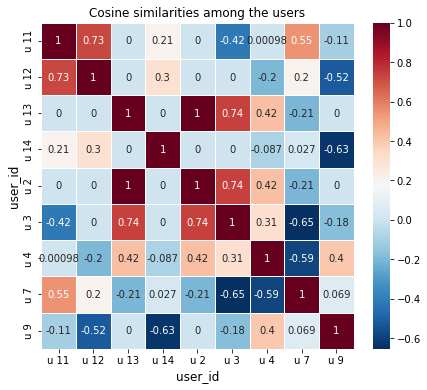

In [31]:
# similarities
fig, ax = plt.subplots(figsize=(7,6)) 
ax.set_title('Cosine similarities among the users',fontsize=12)
ax.set_xlabel('User_id',fontsize=12)
ax.set_ylabel('User_id',fontsize=12)
sns.heatmap(user_similarity_df, 
            xticklabels=user_similarity_df.columns,
            yticklabels=user_similarity_df.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1,
            ax=ax)
# closer the similarity value of a user to 1 is more similar to particular user far from the 1 or less than zero indicates disimilarity


- Calculating similarity among layout

In [32]:
# Normalizing the ratings of users row vector
def normalize_layouts(row):
    new_rows = (row - row.mean())/(row.max() - row.min())
    return new_rows
new_rows_layouts = layout_table.T.apply(normalize)

new_rows_layouts 

user_id,u 11,u 12,u 13,u 14,u 2,u 3,u 4,u 7,u 9
layout_id,,,,,,,,,
GLHS1,-0.525,NaN,NaN,-0.666667,NaN,NaN,-1.0,-0.8,-0.571429
GLHS2,-0.525,NaN,NaN,-0.666667,NaN,NaN,-1.0,-0.8,-0.571429
GLHS3,-0.525,NaN,NaN,-0.666667,NaN,NaN,NaN,NaN,-0.571429
GLHS4,-0.525,NaN,NaN,-0.666667,NaN,NaN,NaN,NaN,NaN
GLHS5,NaN,-0.75,NaN,1.333333,NaN,NaN,NaN,NaN,-0.571429
L1,NaN,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-0.8,NaN
L2,3.475,2.25,NaN,NaN,NaN,NaN,NaN,NaN,-0.571429
L3,1.475,1.25,NaN,NaN,NaN,NaN,-1.0,0.2,NaN
L4,2.475,2.25,NaN,1.333333,NaN,NaN,NaN,NaN,-0.571429


In [33]:
# after normalizing fill nan with 0 
new_rows_layouts = new_rows_layouts.fillna(0)
similarity_layout_matrix = cosine_similarity(new_rows_layouts)
layouts_similarity_df = pd.DataFrame(similarity_layout_matrix, index=layout_table.columns,columns = layout_table.columns)
layouts_similarity_df

layout_id,GLHS1,GLHS2,GLHS3,GLHS4,GLHS5,L1,L2,L3,L4,L5
layout_id,,,,,,,,,,
GLHS1,1.000000,1.000000,0.624150,0.517709,-0.210095,0.464497,-0.218668,0.018316,-0.311540,-0.372947
GLHS2,1.000000,1.000000,0.624150,0.517709,-0.210095,0.464497,-0.218668,0.018316,-0.311540,-0.372947
GLHS3,0.624150,0.624150,1.000000,0.829463,-0.336610,0.000000,-0.350345,-0.346284,-0.499143,-0.554642
GLHS4,0.517709,0.517709,0.829463,1.000000,-0.641452,0.000000,-0.514454,-0.417480,-0.707311,-0.589539
GLHS5,-0.210095,-0.210095,-0.336610,-0.641452,1.000000,0.000000,-0.199422,-0.262631,0.070006,-0.041122
L1,0.464497,0.464497,0.000000,0.000000,0.000000,1.000000,0.000000,0.178399,0.000000,0.106932
L2,-0.218668,-0.218668,-0.350345,-0.514454,-0.199422,0.000000,1.000000,0.868979,0.918174,0.776278
L3,0.018316,0.018316,-0.346284,-0.417480,-0.262631,0.178399,0.868979,1.000000,0.810983,0.648007
L4,-0.311540,-0.311540,-0.499143,-0.707311,0.070006,0.000000,0.918174,0.810983,1.000000,0.628446


<AxesSubplot:title={'center':'Cosine similarities among the Items'}, xlabel='layout_id', ylabel='layout_id'>

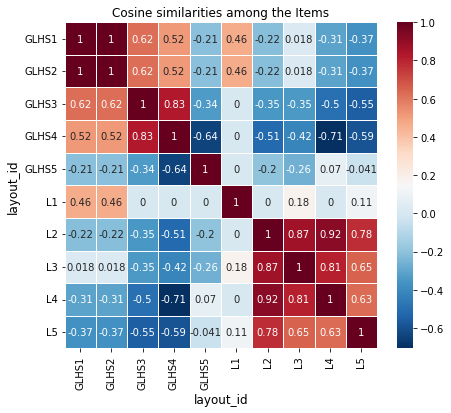

In [34]:
fig, ax = plt.subplots(figsize=(7,6)) 
ax.set_title('Cosine similarities among the Items',fontsize=12)
ax.set_xlabel('Layouts ids',fontsize=12)
ax.set_ylabel('Layouts ids',fontsize=12)
sns.heatmap(layouts_similarity_df, 
            xticklabels=layouts_similarity_df.index,
            yticklabels=layouts_similarity_df.index,
            cmap='RdBu_r',
            annot=True,
            linewidth=1,
            ax=ax)

## Building Item-Item recommender system
- training and testing the recommendation model

In [35]:
# normalizing values
def ratings_normalization(training_df):
    rating_mean= training_df.groupby(['layout_id'], as_index = False, sort = False).mean().rename(columns = {'ratings': 'rating_mean'})[['layout_id','rating_mean']]
    adjusted_ratings = pd.merge(training_df,rating_mean,on = 'layout_id', how = 'left', sort = False)
    adjusted_ratings['rating_adjusted']=adjusted_ratings['ratings'] - adjusted_ratings['rating_mean']
    # replace 0 adjusted rating values to 1*e-8 in order to avoid 0 denominator
    adjusted_ratings.loc[adjusted_ratings['rating_adjusted'] == 0, 'rating_adjusted'] = 1e-8
    return adjusted_ratings,rating_mean

- building model based on the items similarity score
- saving the model

In [36]:
# load_existing_w_matrix: if it is set True, the previous built similarity matrix will be loaded instead of building one
load_existing_w_matrix = False
# building the item-to-item weight matrix

modelpath = 'Models/IBCF'
def build_weight_matrix(adjusted_ratings, load_existing_w_matrix):
    
    # define weight matrix
    w_matrix_columns = ['layout_1', 'layout_2', 'weight']
    w_matrix=pd.DataFrame(columns=w_matrix_columns)
    
    # load weight matrix from pickle file
    if load_existing_w_matrix:
        with open('item_item_weight_matrix', 'rb') as input:
            w_matrix = pickle.load(input)
            #print(w_matrix)
        input.close()
        
    # calculate the similarity values
    else:
        distinct_layouts = np.unique(adjusted_ratings['layout_id'])
        
        i = 0
        
        # for each layout in dataframe
        for layout_1 in distinct_layouts:

            # extract all users who rated layout_1
            user_data = adjusted_ratings[adjusted_ratings['layout_id'] == layout_1]
            distinct_users = np.unique(user_data['user_id'])
            
            # record the ratings for users who rated both layout_1 and layout_2
            record_row_columns = ['user_id', 'layout_1', 'layout_2', 'rating_adjusted_1', 'rating_adjusted_2']
            record_layout_1_2 = pd.DataFrame(columns=record_row_columns)
            
            # for each user u who rated layout_1
            for u_userid in distinct_users:
                
                # user's rating for layout_1
                u_layout_1_rating = user_data[user_data['user_id'] == u_userid]['rating_adjusted'].iloc[0]
                
                # extract layouts rated by the user excluding layout_1
                u_user_data = adjusted_ratings[(adjusted_ratings['user_id'] == u_userid) & (adjusted_ratings['layout_id'] != layout_1)]
                u_distinct_layouts = np.unique(u_user_data['layout_id'])
                
                # for each layout_2 rated by user u 
                for layout_2 in u_distinct_layouts:
                    # the user's rating for layout_2
                    # recording that a user u, who rated layout_1 and layout_2 
                    u_layout_2_rating = u_user_data[u_user_data['layout_id'] == layout_2]['rating_adjusted'].iloc[0]
                    record_row = pd.Series([u_userid, layout_1, layout_2, u_layout_1_rating, u_layout_2_rating], index=record_row_columns)
                    record_layout_1_2 = record_layout_1_2.append(record_row, ignore_index=True)
                    
            # calculate the similarity values between layout_1 and the above recorded layouts
            distinct_layout_2 = np.unique(record_layout_1_2['layout_2'])
            # for each layout 2
            for layout_2 in distinct_layout_2:
                # computing the similarity between layout_l , and layout_2
                paired_layout_1_2 = record_layout_1_2[record_layout_1_2['layout_2'] == layout_2]
                sim_value_numerator = (paired_layout_1_2['rating_adjusted_1'] * paired_layout_1_2['rating_adjusted_2']).sum()
                sim_value_denominator = np.sqrt(np.square(paired_layout_1_2['rating_adjusted_1']).sum()) * np.sqrt(np.square(paired_layout_1_2['rating_adjusted_2']).sum())
                sim_value_denominator = sim_value_denominator if sim_value_denominator != 0 else 1e-8
                sim_value = sim_value_numerator / sim_value_denominator
                w_matrix = w_matrix.append(pd.Series([layout_1, layout_2, sim_value], index=w_matrix_columns), ignore_index=True)
            i = i + 1
        
        get_path = modelpath + '\\'
        # output weight matrix to pickle file
        with open(get_path+'item_item_weight_matrix', 'wb') as output:
            pickle.dump(w_matrix, output, pickle.HIGHEST_PROTOCOL)
        output.close()
    
    return w_matrix


- validating Item based collaborative filtering recommender system

In [37]:
# Measuring the statistical accuracy metrix
def print_validation_rmse_mae(validations_df):
    rmse = None
    mae=None
    if ~validations_df['prediction'].isna().any():
        rmse = (math.sqrt(mean_squared_error(validations_df.ratings, validations_df.prediction)))
        mae = (mean_absolute_error(validations_df.ratings, validations_df.prediction))
    else:
        validations_df.loc[(validations_df['prediction'].isna()),'prediction']=0.0
        rmse = (math.sqrt(mean_squared_error(validations_df.ratings, validations_df.prediction)))
        mae = (mean_absolute_error(validations_df.ratings, validations_df.prediction))
    return rmse,mae

In [38]:
# descision support accuracy measurment 
def average_precision_k(recs, actual):
        score = 0
        num_hits = 0

        for i, p in enumerate(recs):
            #print(i,p)
            TP = p[0] in actual
            if TP:
                num_hits += 1.0
            score += (num_hits / (i + 1.0))
        if score > 0:
            score /= min(len(recs), len(actual))
        #print('average_precision_k',score)
        return score
    
def recall_at_k(recs, actual):

        if len(actual) == 0:
            return 0.0

        TP = set([r[0] for r in recs if r[0] in actual])
        score = (len(TP) / len(actual))
        return score
    
def confusion_matrix_func(recs, actual):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    if len(actual) == 0:
            return 0.0
        
    temp_recs_list=[]
    for r in recs:
        temp_recs_list.append(r[0])
        
    for i in range(len(temp_recs_list)):
        # if layout is recommended and user has interacted with it (TP)
        if temp_recs_list[i] in actual: 
            TP+=1
        # if layout is recommended but user didn't interact with it (FP)
        if temp_recs_list[i] not in actual: 
            FP+=1
    for j in range(len(actual)):
        # if layout was not recommended but user interacted with it (FN)
        if actual[j] not in temp_recs_list: 
            FN+=1
            
    # if layout was not recommended and user didn't interact with it too(TN)
    TN = result.layout_id.nunique() - (TP+FP+FN)
    return TP,FP,FN,TN

In [39]:
def process_confusionMatrix(TP,FP,TN,FN, folds):
    L_TPR = []
    L_TNR = []
    L_PPV = []
    L_NPV = []
    L_FPR = []
    L_FNR = []
    L_FDR = []
    L_ACC = []
    L_F1 = []
    for i in range(folds):
        # Accuracy
        #if TP[i] >0 & FP[i] >0 &FN[i] >0 & TN[i] >0:
        ACC = (TP[i]+TN[i])/(TP[i]+FP[i]+FN[i]+TN[i])
        # Sensitivity, hit rate, recall, or true positive rate 
        TPR = TP[i]/(TP[i]+FN[i])
        # Precision or positive predictive value
        PPV = TP[i]/(TP[i]+FP[i])
        # F1 scroe
        F1 = 2 * (PPV * TPR)/(PPV + TPR)

        L_ACC.append(ACC)
        L_TPR.append(TPR)
        L_PPV.append(PPV)
        L_F1.append(F1)

        # uncomment below to use further evaluation metrics

        # # Specificity or true negative rate
        # TNR = TN[i]/(TN[i]+FP[i]) 
        # # Negative predictive value
        # NPV = TN[i]/(TN[i]+FN[i])
        # # Fall out or false positive rate
        # FPR = FP[i]/(FP[i]+TN[i])
        # # False negative rate
        # FNR = FN[i]/(TP[i]+FN[i])
        # # False discovery rate
        # FDR = FP[i]/(TP[i]+FP[i])
        
        # L_TNR.append(TNR)
        # L_NPV.append(NPV)
        # L_FPR.append(FPR)
        # L_FNR.append(FNR)
        # L_FDR.append(FDR)

        
        print('TPR/Recall: {}, PPV/Precision: {}, Accuracy: {}, F1: {}'.format(TPR,PPV, ACC, F1))
  
    fig = plt.figure(figsize = (5,4))
    ax = fig.add_axes([1,1,1,1])
    ax.set_title('Precision and Recall',fontsize=12)
    ax.set_xlabel('K-folds',fontsize=12)
    ax.set_ylabel('Precision and Recall',fontsize=12)
    ax.plot(L_TPR,label='Recall')
    ax.plot(L_PPV,label='Precision')
    ax.legend()
 
    if len(L_ACC)==folds and len(L_TPR)==folds and len(L_PPV)==folds and len(L_F1)==folds:
        TP_FP_TN_FN = pd.DataFrame()
        for f in range(folds):
            TP_FP_TN_FN.loc[f,'TP'] = TP[f]
            TP_FP_TN_FN.loc[f,'FP'] = FP[f]
            TP_FP_TN_FN.loc[f,'TN'] = TN[f]
            TP_FP_TN_FN.loc[f,'FN'] = FN[f]
        print(TP_FP_TN_FN)
        print('TP{}\n FP{}\n TN{}\n FN{}\n'.format(TP,FP,TN,FN))
        print('L_ACC: {}, L_TPR/Recall: {}, L_PPV/Precision: {}, L_F1: {}'.format(L_ACC,L_TPR,L_PPV,L_F1))
        print('L_ACC_mean/Accuracy: {}, L_TPR_mean/Recall_mean: {}, L_PPV_mean/Precision_mean: {}, , L_F1_mean/F1_Score: {}'
        .format(sum(L_ACC)/len(L_ACC),sum(L_TPR)/len(L_TPR),sum(L_PPV)/len(L_PPV),sum(L_F1)/len(L_F1)))
    


In [40]:
# recommending layouts
def recommend(userID, w_matrix, adjusted_ratings, rating_mean, num_rec):
    distinct_layouts = np.unique(adjusted_ratings['layout_id'])
    user_ratings_all_layouts = pd.DataFrame(columns=['layout_id', 'ratings'])
    user_rated = adjusted_ratings[adjusted_ratings['user_id']==userID]

    # calculate the ratings for all layouts that the user did not rate
    i = 0
    for layout in distinct_layouts:
        user_rating = user_rated[user_rated['layout_id']==layout]
        if user_rating.shape[0] > 0:
            user_ratings_all_layouts.loc[i] = user_rating.iloc[0]
            rating_value = user_ratings_all_layouts.loc[i,'ratings']
        else:
            rating_value = user_ratings_all_layouts.loc[i, 'ratings'] = __predict(userID, layout, w_matrix, adjusted_ratings, rating_mean)
            
        user_ratings_all_layouts.loc[i] = [layout, rating_value]

        i = i + 1

    # select top 5 layout rated by the user
    recs = user_ratings_all_layouts.sort_values(by=['ratings'], ascending=False)

    rated_layouts = adjusted_ratings.loc[(adjusted_ratings.user_id == userID),'layout_id'].tolist()

    new_recs = {}
    i = 0
    for rows in recs.iterrows():
        if rows[1]['layout_id'] not in rated_layouts and i < num_rec:
            new_recs[rows[1]['layout_id']] = {'prediction':rows[1]['ratings']}
            i = i + 1
    sorted_items = list(new_recs.items())
            
    return sorted_items

- making recommendations for the users in test data and considering their rated layouts from train data
- layouts in test data will be considered as if layouts from train data are recommended to one user then how many layouts he interacted with those are taken from test data 

In [41]:
# recommednations based validation
# MAP@K and MAR@K, Precision, Recall, Sensitivity, Accuracy, Error Rate
def IBCF_rec_eval( w_matrix, adjusted_ratings, rating_mean, validation_df, fold, num_rec):
    user_id_count = 0
    no_rec = 0
    total_precision_score = 0
    total_recall_score = 0
    user_ids = []
    apks = []
    arks = []
    TP = []
    FP = []
    TN = []
    FN = []
    for user_id, users_test_data in validation_df.groupby('user_id'):
        user_id_count += 1
        # confirm that users' in test data must exist in the training too
        training_data_for_user = adjusted_ratings[adjusted_ratings['user_id'] == user_id]
        # dictionary contains the layouts visited by current user from training set to find recommendation for each user in test set
        dict_for_rec = training_data_for_user.to_dict(orient='records')   
        
        # recommender will recommend layouts based on "dict_for_rec" recommended layouts will be
        #  compared with relevent_ratings list i.e., considered as user visited layouts after making recommendations 
        relevant_ratings = list(users_test_data['layout_id']) 
        if len(training_data_for_user) >0:
            recs = recommend(user_id, w_matrix, adjusted_ratings, rating_mean,num_rec)
            print(recs)

            if len(recs)>0:
                AP = average_precision_k(recs, relevant_ratings) # average precision@k
                AR = recall_at_k(recs, relevant_ratings) # average recall@k
                tP,fP,fN,tN = confusion_matrix_func(recs, relevant_ratings)
                arks.append(AR)
                apks.append(AP)
                TP.append(tP)
                FP.append(fP)
                TN.append(tN)
                FN.append(fN)
                total_precision_score += AP
                total_recall_score += AR
            else:
                no_rec += 1
            # relevent layout is supposed as the user interaction to the layouts after getting recommendations
            print('user: {}, user visited layouts: {}'.format(user_id,relevant_ratings)) 
            print(' Recommended Layouts',recs) 
    

    tP = sum(TP)
    fP = sum(FP)
    fN = sum(FN)
    tN = sum(TN)
    average_recall = total_recall_score/len(arks) if len(arks) > 0 else 0
    mean_average_precision = total_precision_score/len(apks) if len(apks) > 0 else 0
    output_str = "fold:{} MAP@K {}, MAR@K {}, len-ap {}, len-ar {}, no_recs {}"
    print(output_str.format(fold, mean_average_precision, average_recall, len(apks), len(arks),  no_rec),'\n')
    return (tP,fP,fN,tN)

In [42]:
#  predicting ratings of given layout for the curent user id
def __predict(user_id, layout_id, w_matrix, adjusted_ratings, rating_mean):
    user_other_ratings = adjusted_ratings[adjusted_ratings['user_id'] == user_id]
    user_distinct_layouts = np.unique(user_other_ratings['layout_id'])
    sum_weighted_other_ratings = 0
    sum_weghts = 0
    for layout_j in user_distinct_layouts:
        w_layout_1_2 = w_matrix[(w_matrix['layout_1'] == layout_id) & (w_matrix['layout_2'] == layout_j)]
        if w_layout_1_2.shape[0] > 0:
            user_rating_j = user_other_ratings[user_other_ratings['layout_id']==layout_j]
            sum_weighted_other_ratings += (user_rating_j['ratings'].iloc[0]) * w_layout_1_2['weight'].iloc[0]
            sum_weghts += np.abs(w_layout_1_2['weight'].iloc[0])
    
    # if sum_weights is 0 (which may be because of no ratings from new users/layouts), we used 0 for funk svd so same for this approach too
    if sum_weghts == 0:
        predicted_rating =0
    # sum_weights is bigger than 0
    else:
        predicted_rating = sum_weighted_other_ratings/sum_weghts
    if predicted_rating < 0:
        predicted_rating = 1
    elif predicted_rating > 5:
        predicted_rating = 5
    return predicted_rating


In [43]:
# measuring the statistical accuracy metrix
def Item_Item_CF_eval(ratings_test, w_matrix, adjusted_ratings, rating_mean):
    ratings_test = ratings_test.assign(predicted_rating = pd.Series(np.zeros(ratings_test.shape[0])))
    test_ratings_means = ratings_test.ratings.mean()
    for index, row_rating in ratings_test.iterrows():
        user_id = row_rating['user_id']
        layout_id = row_rating['layout_id']
        ratings_test.loc[(ratings_test.user_id==user_id)&(ratings_test.layout_id==layout_id),'predicted_rating'] = __predict(user_id, layout_id, w_matrix, adjusted_ratings, rating_mean)

    return ratings_test

### k-folds validation of IBCF

In [44]:
def k_fold_training_testing(folds):  
    max_iterations=65
    RMSE_ibcf = []
    MAE_ibcf = []
    fold = 1
    TP=[]
    FP=[]
    TN=[]
    FN=[]
    for train_index, test_index in kf.split(result):
        print('fold: {}'.format(fold))
        columns = result.columns
        validation_df = pd.DataFrame(columns=columns)
        training_df = pd.DataFrame(columns=columns)
        validation_df = result.loc[test_index,:]
        training_df = result.loc[train_index,:]

        adjusted_ratings,rating_mean = ratings_normalization(training_df)
        w_matrix = build_weight_matrix(adjusted_ratings, load_existing_w_matrix)
        predicted_test_ratings = Item_Item_CF_eval(validation_df, w_matrix,adjusted_ratings, rating_mean)
        predicted_test_ratings = predicted_test_ratings.rename(columns={'predicted_rating': 'prediction'})
       
        rmse = None
        mae = None
        rmse , mae = print_validation_rmse_mae(predicted_test_ratings)
        RMSE_ibcf.append(rmse)
        MAE_ibcf.append(mae)
        
        
        tP,fP,fN,tN = IBCF_rec_eval(w_matrix, adjusted_ratings, rating_mean, validation_df,fold, 5)
        TP.append(tP)
        FP.append(fP)
        TN.append(tN)
        FN.append(fN)
        fold =fold+1
        if len(TP)==folds and len(FP)==folds and len(TN)==folds and len(FN)==folds:
            fig = plt.figure(figsize = (5,4))
            ax = fig.add_axes([1,1,1,1])
            ax.set_title('Confusion matrix of k_folds',fontsize=12)
            ax.set_xlabel('K-folds',fontsize=12)
            ax.set_ylabel('TP,FP,FN,TN',fontsize=12)
            ax.plot(range(folds), TP,label = 'TP')
            ax.plot(range(folds), FP,label = 'FP')
            ax.plot(range(folds), TN,label = 'TN')
            ax.plot(range(folds), FN,label = 'FN')
            ax.legend()
            process_confusionMatrix(TP,FP,TN,FN,folds)
        
        
        
    fig = plt.figure(figsize = (5,4))
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('RMSE and MAE on each fold IBCF',fontsize=12)
    ax.set_xlabel('k-folds',fontsize=12)
    ax.set_ylabel('MAE-RMSE',fontsize=12)
    ax.bar(range(folds), RMSE_ibcf,label = 'Root Mean Square Error (RMSE)')
    ax.bar(range(folds), MAE_ibcf,label='Mean Absolute Error (MAE)')
    ax.legend()
    
    print('RMSE: {}, MAE: {}'.format(RMSE_ibcf,MAE_ibcf))
    print('Average RMSE_ibcf: {}, Average MAE_ibcf: {}'.format((sum(RMSE_ibcf))/len(RMSE_ibcf),(sum(MAE_ibcf))/len(MAE_ibcf)))

- spliting data using k-fold cross validation technique

In [45]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(result) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=4, random_state=None, shuffle=False)

KFold(n_splits=5, random_state=None, shuffle=False)


KFold(n_splits=4, random_state=None, shuffle=False)

fold: 1
[('L2', {'prediction': 2.7453160722923955}), ('L4', {'prediction': 2.4456231811705544}), ('GLHS5', {'prediction': 2.345140998500395}), ('GLHS3', {'prediction': 1.7233747959877856}), ('L3', {'prediction': 1.0})]
user: u 7, user visited layouts: ['L3']
 Recommended Layouts [('L2', {'prediction': 2.7453160722923955}), ('L4', {'prediction': 2.4456231811705544}), ('GLHS5', {'prediction': 2.345140998500395}), ('GLHS3', {'prediction': 1.7233747959877856}), ('L3', {'prediction': 1.0})]
fold:1 MAP@K 0.2, MAR@K 1.0, len-ap 1, len-ar 1, no_recs 0 

fold: 2
[('GLHS1', {'prediction': 3.0}), ('GLHS2', {'prediction': 3.0}), ('L4', {'prediction': 3.0}), ('L5', {'prediction': 3.0}), ('GLHS3', {'prediction': 1})]
user: u 7, user visited layouts: ['L1', 'L5', 'GLHS2', 'GLHS1']
 Recommended Layouts [('GLHS1', {'prediction': 3.0}), ('GLHS2', {'prediction': 3.0}), ('L4', {'prediction': 3.0}), ('L5', {'prediction': 3.0}), ('GLHS3', {'prediction': 1})]
[('L4', {'prediction': 1.612574113277207}), ('GLH

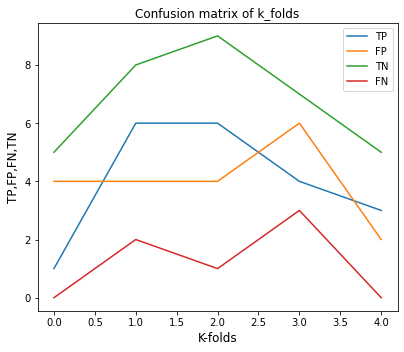

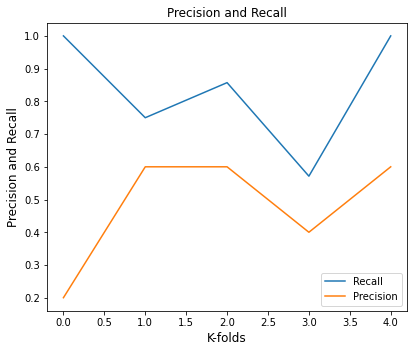

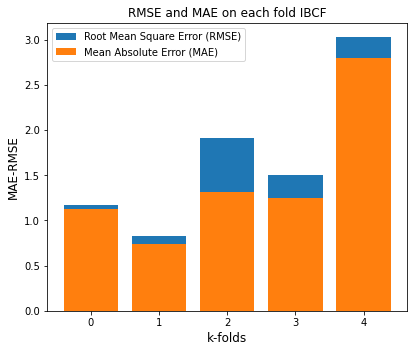

In [46]:
k_fold_training_testing(kf.n_splits)

## IBCF Hold-Out

In [47]:
# splitting data
training_df, validation_df = train_test_split(result, test_size=.2, random_state=42)
training_df = training_df.reset_index()
validation_df = validation_df.reset_index()
print(training_df.shape)
print(validation_df.shape)

(30, 4)
(8, 4)


predicted_test_ratings:    index user_id layout_id  ratings  prediction
0     33    u 11     GLHS2      1.0    2.000000
1     36    u 12     GLHS5      1.0    4.000000
2      4     u 4     GLHS2      1.0    1.000000
3     13     u 9     GLHS2      1.0    1.200000
4     30    u 11        L4      4.0    2.090440
5     26    u 11        L3      3.0    3.000000
6      6     u 4        L3      1.0    1.000000
7     27    u 11        L2      5.0    2.333333


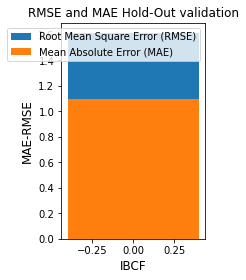

In [23]:
adjusted_ratings,rating_mean = ratings_normalization(training_df)
# find weighted/similarity matrix
w_matrix = build_weight_matrix(adjusted_ratings, load_existing_w_matrix)
# predict ratings of layouts in test/validation data
predicted_test_ratings = Item_Item_CF_eval(validation_df, w_matrix,adjusted_ratings, rating_mean)
predicted_test_ratings = predicted_test_ratings.rename(columns={'predicted_rating': 'prediction'})

print('predicted_test_ratings: {}'.format(predicted_test_ratings))

rmse = None
mae = None
rmse , mae = print_validation_rmse_mae(predicted_test_ratings)

RMSE_ibcf = []
MAE_ibcf = []
RMSE_ibcf.append(rmse)
MAE_ibcf.append(mae)
fig = plt.figure(figsize = (2,3))
ax = fig.add_axes([0,0,1,1])
ax.set_title('RMSE and MAE Hold-Out validation',fontsize=12)
ax.set_xlabel('IBCF',fontsize=12)
ax.set_ylabel('MAE-RMSE',fontsize=12)
ax.bar(range(1), RMSE_ibcf,label = 'Root Mean Square Error (RMSE)')
ax.bar(range(1), MAE_ibcf,label='Mean Absolute Error (MAE)')
ax.legend()

In [24]:
def IBCF_rec_eval_Hold_out( w_matrix, adjusted_ratings, rating_mean, validation_df, rec_num):
    user_id_count = 0
    apks = []
    arks = []
    user_ids = []
    no_rec = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    optimize_layouts_for_users = {}
    total_precision_score = 0
    total_recall_score = 0
    for user_id, users_test_data in validation_df.groupby('user_id'):
        user_id_count += 1
        print('current user: {}'.format(user_id))
        # confirm that users' in test data must exist in the training too
        training_data_for_user = adjusted_ratings[adjusted_ratings['user_id'] == user_id] 
        print('Visited Layouts: \n{}'.format(training_data_for_user))
        # dictionary contains the layouts visited by current user from training set to find recommendation for each user in test set  
        dict_for_rec = training_data_for_user.to_dict(orient='records') 
    
        relevant_ratings = list(users_test_data['layout_id']) 
        if len(training_data_for_user) >0:
            recs = recommend(user_id, w_matrix, adjusted_ratings, rating_mean,rec_num)
            print('\nRecommended Layouts: \n{}'.format(pd.DataFrame(recs)))

            if len(recs)>0:
                AP = average_precision_k(recs, relevant_ratings) # average precision@k
                AR = recall_at_k(recs, relevant_ratings) # average recall@k
                TP,FP,FN,TN = confusion_matrix_func(recs, relevant_ratings)
                arks.append(AR)
                apks.append(AP)
                total_precision_score += AP
                total_recall_score += AR
                print('True_Positive: {}, False_Positive: {}, True_Negative: {}, False_Negative: {}'.format(TP,FP,TN,FN))
                ACC = (TP+TN)/(TP+FP+FN+TN)
                # Sensitivity, hit rate, recall, or true positive rate 
                TPR = TP/(TP+FN)
                # Precision or positive predictive value
                PPV = TP/(TP+FP)
                # F1 scroe
                F1 = 2 * (PPV * TPR)/(PPV + TPR)


                # # Specificity or true negative rate
                # TNR = TN/(TN+FP) 
                # # Negative predictive value
                # NPV = TN/(TN+FN)
                # # Fall out or false positive rate
                # FPR = FP/(FP+TN)
                # # False negative rate
                # FNR = FN/(TP+FN)
                # # False discovery rate
                # FDR = FP/(TP+FP)


                print('TPR/Recall: {}\nPPV/Precision: {}\nAccuracy: {}\nF1: {}\n\n'.format(TPR,PPV, ACC, F1))
            else:
                no_rec += 1


            # relevent layout is supposed as the user interaction to the layouts after getting recommendations
            # print('user: {}, user visited layouts: {}'.format(user_id,relevant_ratings)) 
            # print(' Recommended Layouts',recs) 
            # print()
            # if recommender recommends less than a required number of layouts to a user then optimize most rated layout for that user
            # firstly find who's that user by adding them in the list with the number of missing recommended layouts

            
            if len(recs) < rec_num:
                optimize_layouts_for_users={user_id:(rec_num - len(recs))}
                
    average_recall = total_recall_score/len(arks) if len(arks) > 0 else 0
    mean_average_precision = total_precision_score/len(apks) if len(apks) > 0 else 0
    output_str = "MAP@K {}, MAR@K {}, len-ap {}, len-ar {}, no_recs {}"
    print(output_str.format( mean_average_precision, average_recall, len(apks), len(arks),  no_rec),'\n')
    return optimize_layouts_for_users

In [25]:
optimize_layouts_for_users = IBCF_rec_eval_Hold_out( w_matrix, adjusted_ratings, rating_mean, validation_df,5)

current user: u 11
Visited Layouts: 
    index user_id layout_id  ratings  rating_mean  rating_adjusted
8      32    u 11        L5      5.0     2.750000         2.250000
17     29    u 11     GLHS4      1.0     1.500000        -0.500000
22     31    u 11     GLHS1      1.0     1.400000        -0.400000
29     28    u 11     GLHS3      1.0     1.333333        -0.333333

Recommended Layouts: 
       0                                   1
0     L3                 {'prediction': 3.0}
1     L2  {'prediction': 2.3333333333333335}
2     L1  {'prediction': 2.1441570562617933}
3     L4   {'prediction': 2.090440258462094}
4  GLHS5  {'prediction': 2.0180023604245685}
True_Positive: 3, False_Positive: 2, True_Negative: 4, False_Negative: 1
TPR/Recall: 0.75
PPV/Precision: 0.6
Accuracy: 0.7
F1: 0.6666666666666665


current user: u 12
Visited Layouts: 
    index user_id layout_id  ratings  rating_mean  rating_adjusted
14     37    u 12        L2      4.0          2.5     1.500000e+00
18     35    u 1